# 1. Synthetic Data Generation


# 2. Data Preparation for Activity Prediction


In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

N_DAYS, HOURS_PER_DAY = 60, 24
N_SAMPLES = N_DAYS * HOURS_PER_DAY

print("=" * 80)
print("STREET LIGHT DATASET GENERATION")
print("=" * 80)
print(f"\nGenerating {N_DAYS} days ({N_SAMPLES} hours)...")

# Time
print("\n1. Time index...")
hours = np.tile(np.arange(HOURS_PER_DAY), N_DAYS)
days = np.repeat(np.arange(N_DAYS), HOURS_PER_DAY)
day_of_week = days % 7
time_df = pd.DataFrame({"hour": hours, "day_of_week": day_of_week, "day": days})

# Temperature (always > 0°C)
print("2. Temperature...")
base_temp = 12 + 6 * np.sin(2 * np.pi * (hours - 6) / 24)
temperature = np.maximum(base_temp + np.repeat(np.random.normal(0, 2, N_DAYS), HOURS_PER_DAY) +
                         np.random.normal(0, 1.0, N_SAMPLES), 1.0)

# Fog (RARE, morning/evening only)
print("3. Fog (rare)...")
fog = np.zeros(N_SAMPLES, dtype=int)
in_fog, fog_dur = False, 0
for i in range(N_SAMPLES):
    if in_fog:
        fog[i], fog_dur = 1, fog_dur - 1
        if fog_dur <= 0: in_fog = False
    else:
        h = hours[i]
        prob = 0.08 if 5 <= h <= 8 else (0.05 if 21 <= h <= 23 else 0.0)  # REDUCED probabilities
        if np.random.random() < prob:
            in_fog, fog_dur, fog[i] = True, np.random.randint(3, 7), 1

# Rain (any time, mutually exclusive with fog)
print("4. Rain...")
rain = np.zeros(N_SAMPLES, dtype=int)
in_rain, rain_dur = False, 0
for i in range(N_SAMPLES):
    if fog[i]: continue
    if in_rain:
        rain[i], rain_dur = 1, rain_dur - 1
        if rain_dur <= 0: in_rain = False
    else:
        h = hours[i]
        prob = 0.12 if 14 <= h <= 20 else 0.08
        if np.random.random() < prob:
            in_rain, rain_dur, rain[i] = True, np.random.randint(2, 11), 1

weather_df = pd.DataFrame({"temperature": temperature, "rain": rain, "fog": fog})

# Temperature-weather correlation (rain/fog lower temp)
print("5. Adjusting temperature for weather correlation...")
temperature_adjusted = temperature.copy()
for i in range(N_SAMPLES):
    if rain[i]:
        # Rain causes 2-5°C drop
        temperature_adjusted[i] -= np.random.uniform(2, 5)
    if fog[i]:
        # Fog causes 1-3°C drop
        temperature_adjusted[i] -= np.random.uniform(1, 3)
    # Ensure still above 0°C
    temperature_adjusted[i] = max(1.0, temperature_adjusted[i])

temperature = temperature_adjusted
weather_df['temperature'] = temperature

# Activity (Gaussian centered at 0.55, WEEKDAYS BUSIER, with daily peaks)
print("6. Activity (Gaussian peak at 0.5-0.6, weekdays busier, with daily variation)...")

activity = np.zeros(N_SAMPLES)

for i in range(N_SAMPLES):
    h, is_wknd = hours[i], day_of_week[i] >= 5
    d = days[i]

    base = np.random.normal(0.62, 0.15)

    time_adjustment = 1.0

    if not is_wknd:  # WEEKDAYS - MORE ACTIVE
        if 5 <= h < 7:
            time_adjustment = 0.85  # Less penalty
        elif 7 <= h < 9:
            time_adjustment = 1.20  # MORNING RUSH PEAK
        elif 9 <= h < 12:
            time_adjustment = 1.30  # SHOPPING PEAK
        elif 12 <= h < 14:
            time_adjustment = 1.25  # LUNCH PEAK
        elif 14 <= h < 17:
            time_adjustment = 1.10  # Afternoon steady
        elif 17 <= h < 18:
            time_adjustment = 1.20  # SCHOOL OUT PEAK
        elif 18 <= h < 21:
            time_adjustment = 1.05  # Evening
        elif 21 <= h < 24:
            time_adjustment = 0.88  # Less penalty
        else:
            time_adjustment = 0.70  # Night - less penalty
    else:  # WEEKENDS - DIFFERENT PATTERN
        if 5 <= h < 9:
            time_adjustment = 0.82  # Less penalty
        elif 9 <= h < 12:
            time_adjustment = 0.98  # Closer to average
        elif 12 <= h < 15:
            time_adjustment = 1.25  # LUNCH PEAK
        elif 15 <= h < 18:
            time_adjustment = 1.10  # Afternoon
        elif 18 <= h < 23:
            time_adjustment = 1.20  # EVENING SOCIAL PEAK
        elif 23 <= h < 24:
            time_adjustment = 0.92  # Less penalty
        else:
            time_adjustment = 0.70  # Night - less penalty

    base = base * time_adjustment

    # Add DAILY VARIATION (each day slightly different)
    daily_factor = 1.0 + np.sin(d * 0.3) * 0.08  # ±8% variation per day
    base = base * daily_factor

    # Weather effects
    if rain[i]: base *= 0.50
    if fog[i]: base *= 0.70
    if temperature[i] < 5:
        base *= 0.90
    elif temperature[i] > 25:
        base *= 0.93

    activity[i] = base

# Clip to valid range
activity = np.clip(activity, 0.20, 1.0)
activity_df = pd.DataFrame({"activity_index": activity})

# Visibility
print("7. Visibility (Realistic model based on day cycle + weather)...")

visibility_score = np.zeros(N_SAMPLES)

for i in range(N_SAMPLES):
    h = hours[i]

    # --- A. Natural day cycle (Sun simulation) ---
    # Peak (1.0) at 14:00, trough (0.2) at 2:00 at night.
    # (h - 14) moves the peak for 14:00
    natural_light = 0.6 + 0.4 * np.cos((h - 14) * 2 * np.pi / 24)

    # Add random noise, clouds, shadows
    noise = np.random.normal(0, 0.05)

    current_vis = natural_light + noise

    # --- B. Weather influence ---
    if fog[i] == 1:
        # Fog kills visibility immedietly
        current_vis -= np.random.uniform(0.5, 0.7)
    elif rain[i] == 1:
        # Rain cuts visibility to moderate
        current_vis -= np.random.uniform(0.2, 0.4)

    visibility_score[i] = np.clip(current_vis, 0.0, 1.0)

visibility = np.zeros(N_SAMPLES, dtype=int)

# Discretizing the values, assigning the class
for i in range(N_SAMPLES):
    score = visibility_score[i]
    if score < 0.4:
        visibility[i] = 0
    elif score < 0.75:
        visibility[i] = 1
    else:
        visibility[i] = 2

visibility_df = pd.DataFrame({"visibility": visibility})

print("8. Safety risk (moderately higher at night)...")
night_mult = np.ones(N_SAMPLES)
for i in range(N_SAMPLES):
    h = hours[i]
    # Deep night (midnight to 4am) - highest risk
    if 0 <= h <= 4:
        night_mult[i] = 1.35  # Reduced from 1.8
    # Night hours (10pm-6am) - moderate risk
    elif h >= 22 or h <= 6:
        night_mult[i] = 1.25  # Reduced from 1.5
    # Dusk/dawn transition
    elif h == 7 or h == 19 or h == 20:
        night_mult[i] = 1.15 if h == 20 else 1.10  # Reduced

safety_risk = (0.5 * activity + 0.3 * (2 - visibility) / 2 + 0.2) * night_mult
safety_df = pd.DataFrame({"lighting_level": np.ones(N_SAMPLES), "safety_risk": safety_risk})

# Combine
print("9. Combining...")
dataset = pd.concat([time_df, weather_df, activity_df, visibility_df, safety_df], axis=1)

# Save
print("\n" + "=" * 80)
print("SAVING")
print("=" * 80)
output_path = "street_light_dataset.csv"
dataset.to_csv(output_path, index=False)
print(f"\nSaved: {output_path}")
print(f"Size: {len(dataset)} rows × {len(dataset.columns)} columns")

# Statistics
print("\n" + "=" * 80)
print("STATISTICS")
print("=" * 80)
print(f"\n{'Feature':<20} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
print("-" * 70)
for col in ['hour', 'day_of_week', 'temperature', 'rain', 'fog', 'activity_index', 'visibility', 'safety_risk']:
    print(
        f"{col:<20} {dataset[col].mean():<10.2f} {dataset[col].std():<10.2f} {dataset[col].min():<10.2f} {dataset[col].max():<10.2f}")

weekday_act = activity[day_of_week < 5]
weekend_act = activity[day_of_week >= 5]
print(f"\nWeekday activity:  {weekday_act.mean():.4f}")
print(f"Weekend activity:  {weekend_act.mean():.4f}")
print(f"Difference:        {weekday_act.mean() - weekend_act.mean():.4f}")
print(f"                   ({((weekday_act.mean() / weekend_act.mean() - 1) * 100):.1f}% higher on weekdays) ✓")

print(f"\nRain: {rain.sum()}h ({100 * rain.sum() / N_SAMPLES:.1f}%)")
print(f"Fog:  {fog.sum()}h ({100 * fog.sum() / N_SAMPLES:.1f}%) [RARE] ✓")
print(f"Rain & Fog overlap: {((rain == 1) & (fog == 1)).sum()} ✓")
print(f"Temp > 0°C: {(temperature > 0).all()} ✓")
print(f"Activity never zero: {(activity >= 0.12).all()} ✓")

rain_red = (1 - dataset[dataset['rain'] == 1]['activity_index'].mean() / dataset[dataset['rain'] == 0][
    'activity_index'].mean()) * 100
fog_red = (1 - dataset[dataset['fog'] == 1]['activity_index'].mean() / dataset[dataset['fog'] == 0][
    'activity_index'].mean()) * 100
print(f"\nRain impact: {rain_red:.1f}% reduction")
print(f"Fog impact:  {fog_red:.1f}% reduction")

# Temperature-weather correlation
print("\n" + "-" * 80)
print("TEMPERATURE-WEATHER CORRELATION")
print("-" * 80)
temp_no_rain = dataset[dataset['rain'] == 0]['temperature'].mean()
temp_rain = dataset[dataset['rain'] == 1]['temperature'].mean()
temp_no_fog = dataset[dataset['fog'] == 0]['temperature'].mean()
temp_fog = dataset[dataset['fog'] == 1]['temperature'].mean()
print(f"Temperature without rain: {temp_no_rain:.2f}°C")
print(f"Temperature with rain:    {temp_rain:.2f}°C (drop: {temp_no_rain - temp_rain:.2f}°C) ✓")
print(f"Temperature without fog:  {temp_no_fog:.2f}°C")
print(f"Temperature with fog:     {temp_fog:.2f}°C (drop: {temp_no_fog - temp_fog:.2f}°C) ✓")

day_mask = (dataset['hour'] >= 7) & (dataset['hour'] <= 19)
print(f"\nNight safety: {dataset[~day_mask]['safety_risk'].mean():.3f}")
print(f"Day safety:   {dataset[day_mask]['safety_risk'].mean():.3f}")
print(f"Multiplier:   {dataset[~day_mask]['safety_risk'].mean() / dataset[day_mask]['safety_risk'].mean():.2f}x ✓")

STREET LIGHT DATASET GENERATION

Generating 60 days (1440 hours)...

1. Time index...
2. Temperature...
3. Fog (rare)...
4. Rain...
5. Adjusting temperature for weather correlation...
6. Activity (Gaussian peak at 0.5-0.6, weekdays busier, with daily variation)...
7. Visibility (Realistic model based on day cycle + weather)...
8. Safety risk (moderately higher at night)...
9. Combining...

SAVING

Saved: street_light_dataset.csv
Size: 1440 rows × 10 columns

STATISTICS

Feature              Mean       Std        Min        Max       
----------------------------------------------------------------------
hour                 11.50      6.92       0.00       23.00     
day_of_week          2.90       1.99       0.00       6.00      
temperature          10.18      4.98       1.00       22.39     
rain                 0.39       0.49       0.00       1.00      
fog                  0.12       0.32       0.00       1.00      
activity_index       0.47       0.21       0.20       1.00      

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)

# Load dataset
print("\nLoading dataset...")
dataset = pd.read_csv("street_light_dataset.csv")
print(f"Loaded: {len(dataset)} samples")

sns.set_style("whitegrid")
time_axis = np.arange(len(dataset))
week_hours, start, end = 7*24, 0, 7*24
t_week = np.arange(week_hours)

# 1. Feature Distributions
print("\n1/12: Feature distributions...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')

axes[0,0].hist(dataset['hour'], bins=24, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Hour'); axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(dataset['day_of_week'], bins=7, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Day of Week'); axes[0,1].set_xticks(range(7)); axes[0,1].grid(True, alpha=0.3)

axes[0,2].hist(dataset['temperature'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0,2].set_title('Temperature (>0°C)'); axes[0,2].axvline(0, color='red', linestyle='--', label='Freezing')
axes[0,2].legend(); axes[0,2].grid(True, alpha=0.3)

axes[1,0].bar(['No Rain','Rain'], dataset['rain'].value_counts().sort_index(), color=['skyblue','darkblue'], alpha=0.7)
axes[1,0].set_title(f"Rain: {dataset['rain'].sum()}h"); axes[1,0].grid(True, alpha=0.3, axis='y')

axes[1,1].bar(['No Fog','Fog'], dataset['fog'].value_counts().sort_index(), color=['lightgray','gray'], alpha=0.7)
axes[1,1].set_title(f"Fog: {dataset['fog'].sum()}h (RARE)"); axes[1,1].grid(True, alpha=0.3, axis='y')

axes[1,2].hist(dataset['activity_index'], bins=30, edgecolor='black', alpha=0.7, color='darkred')
axes[1,2].set_title('Activity (More Gaussian)'); axes[1,2].axvline(0.12, color='red', linestyle='--', label='Min')
axes[1,2].legend(); axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("01_feature_distributions.png", dpi=150, bbox_inches='tight')
plt.close()

# 2. Activity by Hour
print("2/12: Activity by hour...")
fig, ax = plt.subplots(figsize=(14, 6))
box_data = [dataset[dataset['hour']==h]['activity_index'].values for h in range(24)]
bp = ax.boxplot(box_data, tick_labels=range(24), patch_artist=True)
[patch.set_facecolor('lightcoral') for patch in bp['boxes']]
ax.set_title('Activity by Hour', fontsize=14, fontweight='bold')
ax.axhline(dataset['activity_index'].mean(), color='red', linestyle='--', label=f"Mean: {dataset['activity_index'].mean():.3f}")
ax.axhline(0.12, color='blue', linestyle=':', label='Min')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("02_activity_by_hour.png", dpi=150, bbox_inches='tight')
plt.close()

# 3. Weekday vs Weekend
print("3/12: Weekday vs weekend...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
box_data_days = [dataset[dataset['day_of_week']==d]['activity_index'].values for d in range(7)]
bp = axes[0].boxplot(box_data_days, tick_labels=day_names, patch_artist=True)
[patch.set_facecolor('lightblue' if i>=5 else 'lightgreen') for i, patch in enumerate(bp['boxes'])]
axes[0].set_title('Activity by Day (Weekdays Busier)'); axes[0].grid(True, alpha=0.3)

day_means = dataset.groupby('day_of_week')['activity_index'].mean()
axes[1].bar(day_names, day_means, color=['lightgreen']*5+['lightblue']*2, edgecolor='black', alpha=0.7)
axes[1].axhline(dataset['activity_index'].mean(), color='red', linestyle='--', label='Overall Mean')
axes[1].set_title('Mean Activity by Day'); axes[1].legend(); axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("03_weekday_vs_weekend.png", dpi=150, bbox_inches='tight')
plt.close()

# 4. Weather Impact
print("4/12: Weather impact...")
dataset['weather'] = 'Clear'
dataset.loc[dataset['rain']==1, 'weather'] = 'Rain'
dataset.loc[dataset['fog']==1, 'weather'] = 'Fog'

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for idx, cond in enumerate(['rain', 'fog']):
    groups = dataset.groupby(cond)['activity_index'].agg(['mean', 'std', 'count'])
    axes[idx].bar([f'No {cond.title()}', cond.title()], groups['mean'], yerr=groups['std'], capsize=10,
                  color=['skyblue','darkblue'] if cond=='rain' else ['lightgray','gray'], alpha=0.7)
    axes[idx].set_title(f'{cond.title()} Impact ({"50%" if cond=="rain" else "30%"} reduction)')
    axes[idx].grid(True, alpha=0.3, axis='y')

w_groups = dataset.groupby('weather')['activity_index'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
axes[2].bar(range(len(w_groups)), w_groups['mean'], yerr=w_groups['std'], capsize=10, color=['gold','gray','darkblue'], alpha=0.7)
axes[2].set_xticks(range(len(w_groups))); axes[2].set_xticklabels(w_groups.index)
axes[2].set_title('Weather (Mutually Exclusive)'); axes[2].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("04_weather_impact.png", dpi=150, bbox_inches='tight')
plt.close()

# 5. Hour vs Temp (Activity colors)
print("5/12: Hour vs temperature...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sc = axes[0].scatter(dataset['hour'], dataset['temperature'], c=dataset['activity_index'],
                     cmap='coolwarm', alpha=0.5, s=15)
axes[0].set_xlabel('Hour'); axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Hour vs Temperature (colored by Activity)')
axes[0].set_xticks(range(0, 24, 2)); axes[0].grid(True, alpha=0.3)
plt.colorbar(sc, ax=axes[0], label='Activity')

temp_bins = pd.cut(dataset['temperature'], bins=10)
temp_act = dataset.groupby(temp_bins, observed=True)['activity_index'].agg(['mean', 'std'])
temp_centers = [interval.mid for interval in temp_act.index]
axes[1].errorbar(temp_centers, temp_act['mean'], yerr=temp_act['std'], fmt='o-', capsize=5)
axes[1].set_xlabel('Temperature (°C)'); axes[1].set_ylabel('Mean Activity')
axes[1].set_title('Activity by Temperature'); axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("05_hour_temp_activity.png", dpi=150, bbox_inches='tight')
plt.close()

# 6. Correlation Heatmap
print("6/12: Correlation heatmap...")
fig, ax = plt.subplots(figsize=(10, 8))
cols = ['hour', 'day_of_week', 'temperature', 'rain', 'fog', 'activity_index', 'visibility', 'safety_risk']
corr = dataset[cols].corr()
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=1, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig("06_correlation_heatmap.png", dpi=150, bbox_inches='tight')
plt.close()

# 7. Time Series
print("7/12: Time series...")
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

tr = range(week_hours)
axes[0].plot(tr, dataset['activity_index'].iloc[tr], 'darkred', linewidth=1.5, label='Activity')
rain_mask = dataset['rain'].iloc[tr]==1
fog_mask = dataset['fog'].iloc[tr]==1
axes[0].scatter(np.where(rain_mask)[0], dataset['activity_index'].iloc[tr][rain_mask],
               marker='v', s=80, c='blue', alpha=0.6, label='Rain')
axes[0].scatter(np.where(fog_mask)[0], dataset['activity_index'].iloc[tr][fog_mask],
               marker='o', s=60, c='gray', alpha=0.6, label='Fog')
axes[0].set_title('Activity with Weather (Week 1)', fontweight='bold')
axes[0].legend(); axes[0].grid(True, alpha=0.3)
ax2 = axes[0].twinx()
ax2.plot(tr, dataset['temperature'].iloc[tr], 'orange', alpha=0.4, linewidth=1)
ax2.set_ylabel('Temp (°C)', color='orange'); ax2.tick_params(axis='y', labelcolor='orange')

sr = range(min(14*24, len(dataset)))
norm_data = dataset[['temperature', 'activity_index']].iloc[sr].copy()
norm_data['temperature'] = (norm_data['temperature'] - norm_data['temperature'].min()) / (norm_data['temperature'].max() - norm_data['temperature'].min())
axes[1].plot(sr, norm_data['activity_index'], 'darkred', linewidth=1.5, label='Activity')
axes[1].plot(sr, norm_data['temperature'], 'orange', linewidth=1, alpha=0.7, label='Temp (scaled)')
axes[1].set_title('Normalized Features (2 Weeks)', fontweight='bold')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

hourly = dataset.groupby('hour')['activity_index'].agg(['mean', 'std'])
axes[2].plot(hourly.index, hourly['mean'], 'o-', linewidth=2, color='darkred', label='Mean')
axes[2].fill_between(hourly.index, hourly['mean']-hourly['std'], hourly['mean']+hourly['std'], alpha=0.3, color='red')
axes[2].set_title('Average Daily Pattern', fontweight='bold')
axes[2].set_xlabel('Hour'); axes[2].legend(); axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("07_time_series.png", dpi=150, bbox_inches='tight')
plt.close()

# 8. Feature Interactions
print("8/12: Feature interactions...")
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

rain_hour = dataset.groupby(['hour', 'rain'])['activity_index'].mean().unstack()
axes[0,0].plot(rain_hour.index, rain_hour[0], 'o-', label='No Rain')
axes[0,0].plot(rain_hour.index, rain_hour[1], 's-', label='Rain')
axes[0,0].set_title('Rain Effect by Hour'); axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

fog_hour = dataset.groupby(['hour', 'fog'])['activity_index'].mean().unstack()
axes[0,1].plot(fog_hour.index, fog_hour[0], 'o-', label='No Fog')
axes[0,1].plot(fog_hour.index, fog_hour[1], 's-', label='Fog')
axes[0,1].set_title('Fog Effect by Hour'); axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

dataset['is_weekend'] = dataset['day_of_week'] >= 5
wknd_hour = dataset.groupby(['hour', 'is_weekend'])['activity_index'].mean().unstack()
axes[1,0].plot(wknd_hour.index, wknd_hour[False], 'o-', label='Weekday', linewidth=2)
axes[1,0].plot(wknd_hour.index, wknd_hour[True], 's-', label='Weekend', linewidth=2)
axes[1,0].set_title('Weekday vs Weekend by Hour (Weekdays Higher)', fontweight='bold'); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

pivot = dataset.pivot_table(values='activity_index', index='hour', columns='day_of_week')
sns.heatmap(pivot, cmap='YlOrRd', ax=axes[1,1], cbar_kws={'label': 'Activity'})
axes[1,1].set_title('Hour × Day Heatmap'); axes[1,1].set_xlabel('Day (0=Mon, 6=Sun)')
plt.tight_layout()
plt.savefig("08_feature_interactions.png", dpi=150, bbox_inches='tight')
plt.close()

# 9. Visibility
print("9/12: Visibility...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

vis_counts = dataset['visibility'].value_counts().sort_index()
axes[0,0].bar(['Poor', 'Moderate', 'Good'], vis_counts, color=['red','orange','green'], alpha=0.7)
axes[0,0].set_title('Visibility Distribution'); axes[0,0].grid(True, alpha=0.3, axis='y')

axes[0,1].scatter(time_axis, dataset['visibility'], c=dataset['visibility'], cmap='RdYlGn', s=3, alpha=0.5)
axes[0,1].set_title('Visibility Timeline'); axes[0,1].grid(True, alpha=0.3)

vis_hour = dataset.groupby(['hour', 'visibility']).size().unstack(fill_value=0)
vis_pct = vis_hour.div(vis_hour.sum(axis=1), axis=0) * 100
axes[1,0].bar(vis_pct.index, vis_pct[2], label='Good', color='green', alpha=0.7)
axes[1,0].bar(vis_pct.index, vis_pct[1], bottom=vis_pct[2], label='Moderate', color='orange', alpha=0.7)
axes[1,0].bar(vis_pct.index, vis_pct[0], bottom=vis_pct[2]+vis_pct[1], label='Poor', color='red', alpha=0.7)
axes[1,0].set_title('Visibility by Hour'); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3, axis='y')

axes[1,1].scatter(t_week, dataset['visibility'].iloc[start:end], c=dataset['visibility'].iloc[start:end], cmap='RdYlGn', s=30)
axes[1,1].set_title('Visibility (Week 1)'); axes[1,1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("09_visibility.png", dpi=150, bbox_inches='tight')
plt.close()

# 10. Safety Risk
print("10/12: Safety risk...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].hist(dataset['safety_risk'], bins=40, edgecolor='black', alpha=0.7, color='crimson')
axes[0,0].axvline(dataset['safety_risk'].mean(), color='blue', linestyle='--', label=f"Mean: {dataset['safety_risk'].mean():.3f}")
axes[0,0].set_title('Safety Risk (Higher at Night)'); axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(time_axis, dataset['safety_risk'], 'crimson', linewidth=0.6, alpha=0.8)
axes[0,1].set_title('Safety Risk Timeline'); axes[0,1].grid(True, alpha=0.3)

risk_hour = dataset.groupby('hour')['safety_risk'].agg(['mean', 'std'])
axes[1,0].plot(risk_hour.index, risk_hour['mean'], 'o-', linewidth=2, color='crimson')
axes[1,0].fill_between(risk_hour.index, risk_hour['mean']-risk_hour['std'], risk_hour['mean']+risk_hour['std'], alpha=0.3, color='red')
axes[1,0].axvspan(20, 24, alpha=0.2, color='gray', label='Night')
axes[1,0].axvspan(0, 6, alpha=0.2, color='gray')
axes[1,0].set_title('Safety Risk by Hour'); axes[1,0].set_xticks(range(0, 24, 2)); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(t_week, dataset['safety_risk'].iloc[start:end], 'crimson', linewidth=1.2)
axes[1,1].set_title('Safety Risk (Week 1)'); axes[1,1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("10_safety_risk.png", dpi=150, bbox_inches='tight')
plt.close()

# 11. Weather Timeline
print("11/12: Weather timeline...")
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Plot 1: Rain, Fog, and Clear on timeline
rain_idx = np.where(dataset['rain']==1)[0]
fog_idx = np.where(dataset['fog']==1)[0]
clear_idx = np.where((dataset['rain']==0) & (dataset['fog']==0))[0]

axes[0].scatter(rain_idx, np.ones(len(rain_idx))*2, marker='|', s=200, c='blue', alpha=0.6, label='Rain')
axes[0].scatter(fog_idx, np.ones(len(fog_idx)), marker='|', s=200, c='gray', alpha=0.6, label='Fog')
axes[0].scatter(clear_idx, np.zeros(len(clear_idx)), marker='|', s=100, c='gold', alpha=0.3, label='Clear')
axes[0].set_title('Weather Timeline (Fog is RARE)', fontweight='bold')
axes[0].set_yticks([0, 1, 2]); axes[0].set_yticklabels(['Clear', 'Fog', 'Rain'])
axes[0].legend(loc='upper right'); axes[0].grid(True, alpha=0.3)

# Plot 2: Weather by hour with Clear
rain_h = dataset.groupby('hour')['rain'].sum()
fog_h = dataset.groupby('hour')['fog'].sum()
clear_h = dataset.groupby('hour').apply(lambda x: ((x['rain']==0) & (x['fog']==0)).sum())

x, width = np.arange(24), 0.25
axes[1].bar(x-width, rain_h, width, label='Rain (any time)', color='blue', alpha=0.7)
axes[1].bar(x, fog_h, width, label='Fog (morning/evening, rare)', color='gray', alpha=0.7)
axes[1].bar(x+width, clear_h, width, label='Clear (most common)', color='gold', alpha=0.7)
axes[1].set_title('Weather by Hour'); axes[1].set_xticks(x); axes[1].legend(); axes[1].grid(True, alpha=0.3, axis='y')

cats = ['Rain Only', 'Fog Only', 'Clear', 'Both (Should be 0)']
counts = [
    ((dataset['rain']==1)&(dataset['fog']==0)).sum(),
    ((dataset['rain']==0)&(dataset['fog']==1)).sum(),
    ((dataset['rain']==0)&(dataset['fog']==0)).sum(),
    ((dataset['rain']==1)&(dataset['fog']==1)).sum()
]
axes[2].bar(cats, counts, color=['blue','gray','gold','red'], alpha=0.7)
[axes[2].text(i, counts[i]+10, str(counts[i]), ha='center', fontweight='bold') for i in range(4)]
axes[2].set_title('Weather Verification'); axes[2].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("11_weather_timeline.png", dpi=150, bbox_inches='tight')
plt.close()

# 12. PCA
print("12/12: PCA analysis...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

pca_features = ['hour', 'day_of_week', 'temperature', 'rain', 'fog', 'activity_index', 'visibility']
X = StandardScaler().fit_transform(dataset[pca_features])
pca = PCA()
X_pca = pca.fit_transform(X)

# Explained variance
axes[0,0].bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, alpha=0.7)
axes[0,0].plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
axes[0,0].set_title('PCA Explained Variance\n(How much info each component captures)', fontsize=11)
axes[0,0].set_xlabel('Principal Component')
axes[0,0].set_ylabel('Variance Explained')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].text(0.5, 0.95, f'PC1+PC2 explain {np.cumsum(pca.explained_variance_ratio_)[1]*100:.1f}% of variance',
              transform=axes[0,0].transAxes, ha='left', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# First 2 PCs colored by activity
sc = axes[0,1].scatter(X_pca[:, 0], X_pca[:, 1], c=dataset['activity_index'], cmap='coolwarm', alpha=0.5, s=10)
axes[0,1].set_title('First 2 Principal Components\n(Each point is an hour, color = activity)', fontsize=11)
axes[0,1].set_xlabel('PC1 (Main pattern)')
axes[0,1].set_ylabel('PC2 (Secondary pattern)')
axes[0,1].grid(True, alpha=0.3)
plt.colorbar(sc, ax=axes[0,1], label='Activity')

# PC1 contributions
pc1_contrib = pd.Series(pca.components_[0], index=pca_features)
pc1_contrib.plot(kind='barh', ax=axes[1,0], color='steelblue', alpha=0.7)
axes[1,0].set_title('PC1 Feature Contributions\n(What drives the main pattern?)', fontsize=11)
axes[1,0].set_xlabel('Contribution (positive = correlated)')
axes[1,0].grid(True, alpha=0.3)
# Add interpretation
top_feature = pc1_contrib.abs().idxmax()
axes[1,0].text(0.02, 0.98, f'Dominated by: {top_feature}',
              transform=axes[1,0].transAxes, ha='left', va='top', fontsize=9,
              bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# PC2 contributions
pc2_contrib = pd.Series(pca.components_[1], index=pca_features)
pc2_contrib.plot(kind='barh', ax=axes[1,1], color='coral', alpha=0.7)
axes[1,1].set_title('PC2 Feature Contributions\n(What drives the secondary pattern?)', fontsize=11)
axes[1,1].set_xlabel('Contribution')
axes[1,1].grid(True, alpha=0.3)
# Add interpretation
top_feature2 = pc2_contrib.abs().idxmax()
axes[1,1].text(0.02, 0.98, f'Dominated by: {top_feature2}',
              transform=axes[1,1].transAxes, ha='left', va='top', fontsize=9,
              bbox=dict(boxstyle='round', facecolor='lightsalmon', alpha=0.5))

plt.tight_layout()
plt.savefig("12_pca_analysis.png", dpi=150, bbox_inches='tight')
plt.close()

print("\n" + "=" * 80)
print("✓ ALL 12 VISUALIZATIONS COMPLETE!")
print("=" * 80)
print("\nGenerated files:")
for i in range(1, 13):
    print(f"  {i:02d}_*.png")

# Print PCA explanation
print("\n" + "=" * 80)
print("PCA ANALYSIS EXPLANATION")
print("=" * 80)

CREATING VISUALIZATIONS

Loading dataset...
Loaded: 1440 samples

1/12: Feature distributions...
2/12: Activity by hour...
3/12: Weekday vs weekend...
4/12: Weather impact...
5/12: Hour vs temperature...
6/12: Correlation heatmap...
7/12: Time series...
8/12: Feature interactions...
9/12: Visibility...
10/12: Safety risk...
11/12: Weather timeline...


/var/folders/np/d69lmmf50mnbp9mzgwgsxhk00000gn/T/ipykernel_81320/3362696624.py:264: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clear_h = dataset.groupby('hour').apply(lambda x: ((x['rain']==0) & (x['fog']==0)).sum())


12/12: PCA analysis...

✓ ALL 12 VISUALIZATIONS COMPLETE!

Generated files:
  01_*.png
  02_*.png
  03_*.png
  04_*.png
  05_*.png
  06_*.png
  07_*.png
  08_*.png
  09_*.png
  10_*.png
  11_*.png
  12_*.png

PCA ANALYSIS EXPLANATION


# 3. Activity prediction using ANN  


In [3]:
# Select input features and target variable
feature_columns = [
    "hour",
    "day_of_week",
    "temperature",
    "rain",
    "fog"
]

target_column = "activity_index"

X = dataset[feature_columns].copy()
y = dataset[target_column].copy()


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# spitting the data chronologically
split_index = int(0.8 * len(X))

X_train_raw = X.iloc[:split_index].copy()
X_val_raw = X.iloc[split_index:].copy()

y_train = y.iloc[:split_index].values
y_val = y.iloc[split_index:].values

# - hour, day_of_week -> MinMaxScaler (0-1)
# - temperature -> StandardScaler (mean 0, std 1)
# - rain, fog -> passthrough (no changess - the values are already bianry)
preprocessor = ColumnTransformer(
    transformers=[
        ('num_bounded', MinMaxScaler(), ['hour', 'day_of_week']),
        ('num_continuous', StandardScaler(), ['temperature']),
        ('binary', 'passthrough', ['rain', 'fog'])
    ],
    verbose_feature_names_out=False
)

preprocessor.fit(X_train_raw)

X_train = preprocessor.transform(X_train_raw)
X_val = preprocessor.transform(X_val_raw)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print("\nPrzykładowy wiersz treningowy (po skalowaniu):")
# Kolejność: hour, day, temp, rain, fog
print(X_train[0])

Training samples: 1152
Validation samples: 288

Przykładowy wiersz treningowy (po skalowaniu):
[ 0.          0.         -0.71102744  0.          0.        ]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)


In [6]:
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Changed shuffle=False for time-series data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 18
Val batches: 5


In [7]:
class ActivityPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout_rate=0.2):
        super(ActivityPredictor, self).__init__()

        self.model = nn.Sequential(
            # input layer
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # second hidden layer - half the neurons
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # output layer
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return self.model(x)

# checking the dimension
input_dim = X_train.shape[1]
print(f"Model input dimension: {input_dim}")

Model input dimension: 5


Rozpoczynam szczegółowe porównanie (50 epok)...
--------------------------------------------------------------------------------
Optimizer    | Min Val Loss | Final MSE    | Final R2  
--------------------------------------------------------------------------------
Adam         | 0.01950      | 0.01951      | 0.5016
RMSprop      | 0.01939      | 0.01937      | 0.5052
SGD          | 0.02137      | 0.02082      | 0.4683
AdamW        | 0.01921      | 0.01868      | 0.5229


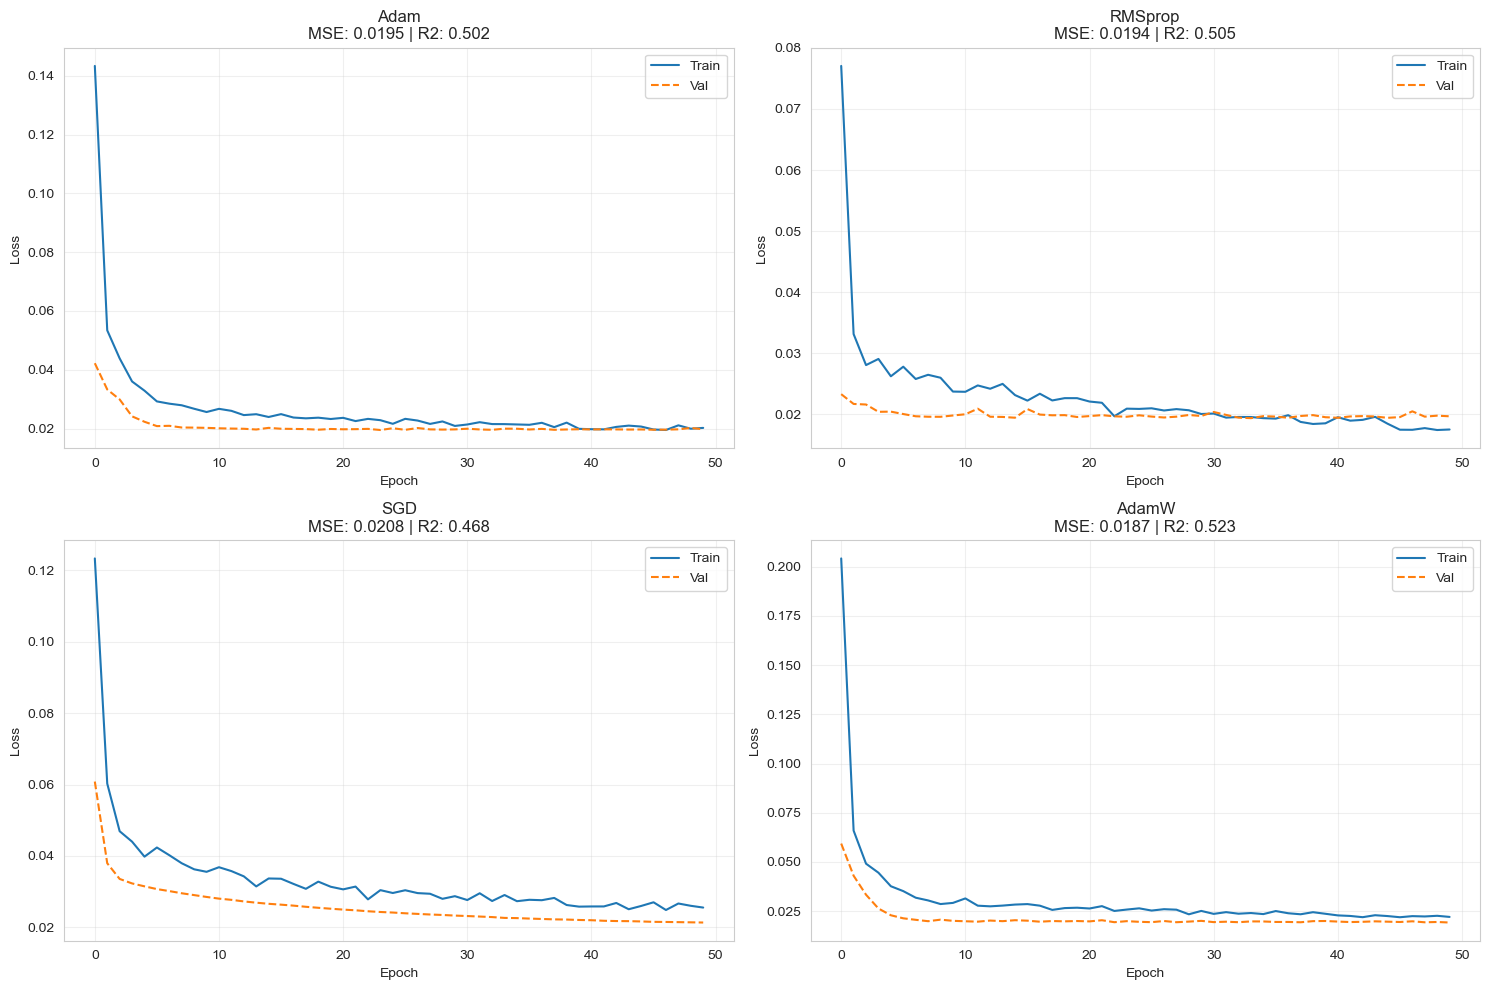

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# comparing the optimizers
optimizer_candidates = ['Adam', 'RMSprop', 'SGD', 'AdamW']
N_EPOCHS_COMPARE = 50
results_data = []

plt.figure(figsize=(15, 10))
print(f"Rozpoczynam szczegółowe porównanie ({N_EPOCHS_COMPARE} epok)...")
print("-" * 80)
print(f"{'Optimizer':<12} | {'Min Val Loss':<12} | {'Final MSE':<12} | {'Final R2':<10}")
print("-" * 80)

best_val_loss = float('inf')
best_optimizer_name = 'Adam'

for i, opt_name in enumerate(optimizer_candidates):
    # 1. Reset the model
    model = ActivityPredictor(input_dim)
    criterion = nn.MSELoss()

    if opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif opt_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif opt_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=0.001)

    train_losses = []
    val_losses = []

    for epoch in range(N_EPOCHS_COMPARE):
        model.train()
        batch_losses = []
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            pred = model(X_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        train_losses.append(np.mean(batch_losses))

        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_b, y_b in val_loader:
                pred = model(X_b)
                loss = criterion(pred, y_b)
                val_batch_losses.append(loss.item())
        val_losses.append(np.mean(val_batch_losses))

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_val_tensor)
        y_pred = y_pred_tensor.cpu().numpy().flatten()
        y_true = y_val_tensor.cpu().numpy().flatten()

    final_mse = mean_squared_error(y_true, y_pred)
    final_r2 = r2_score(y_true, y_pred)
    min_loss = min(val_losses)

    results_data.append({
        'name': opt_name,
        'mse': final_mse,
        'r2': final_r2,
        'min_loss': min_loss
    })

    print(f"{opt_name:<12} | {min_loss:.5f}      | {final_mse:.5f}      | {final_r2:.4f}")

    if min_loss < best_val_loss:
        best_val_loss = min_loss
        best_optimizer_name = opt_name

    plt.subplot(2, 2, i+1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val', linestyle='--')
    plt.title(f"{opt_name}\nMSE: {final_mse:.4f} | R2: {final_r2:.3f}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# optimizers chosen - adam
N_EPOCHS_FINAL = 50
final_model = ActivityPredictor(input_dim)
criterion = nn.MSELoss()

optimizer = optim.Adam(final_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

history = {'train_loss': [], 'val_loss': []}

for epoch in range(N_EPOCHS_FINAL):

    final_model.train()
    running_loss = 0.0
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        pred = final_model(X_b)
        loss = criterion(pred, y_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_b.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)

    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            pred = final_model(X_b)
            loss = criterion(pred, y_b)
            running_val_loss += loss.item() * X_b.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)

    scheduler.step(epoch_val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{N_EPOCHS_FINAL} | Train Loss: {epoch_train_loss:.5f} | Val Loss: {epoch_val_loss:.5f}")

print("Trening zakończony.")

Epoch 10/50 | Train Loss: 0.02212 | Val Loss: 0.02044
Epoch 20/50 | Train Loss: 0.02051 | Val Loss: 0.02000
Epoch 30/50 | Train Loss: 0.01892 | Val Loss: 0.01935
Epoch 40/50 | Train Loss: 0.01952 | Val Loss: 0.01938
Epoch 50/50 | Train Loss: 0.01808 | Val Loss: 0.01938
Trening zakończony.



EVALUATION
MAE (Mean Error):       0.1040
RMSE (Error Squared): 0.1392
R2 Score:   0.5050


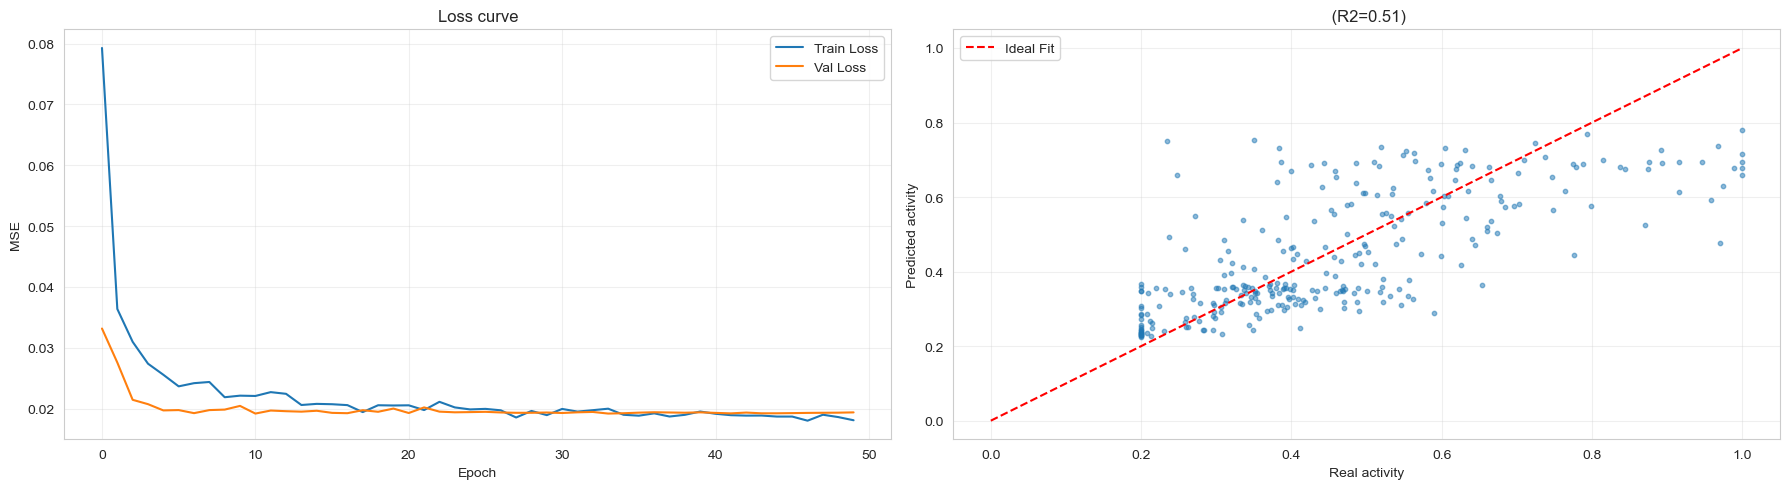

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

final_model.eval()
with torch.no_grad():
    y_pred_tensor = final_model(X_val_tensor)
    y_pred = y_pred_tensor.cpu().numpy().flatten()
    y_true = y_val_tensor.cpu().numpy().flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n" + "="*40)
print("EVALUATION")
print("="*40)
print(f"MAE (Mean Error):       {mae:.4f}")
print(f"RMSE (Error Squared): {rmse:.4f}")
print(f"R2 Score:   {r2:.4f}")

plt.figure(figsize=(18, 5))

# Learning Curve
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True, alpha=0.3)

#  Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5, s=10)
plt.plot([0, 1], [0, 1], 'r--', label='Ideal Fit') # Linia idealna
plt.title(f' (R2={r2:.2f})')
plt.xlabel('Real activity')
plt.ylabel('Predicted activity')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

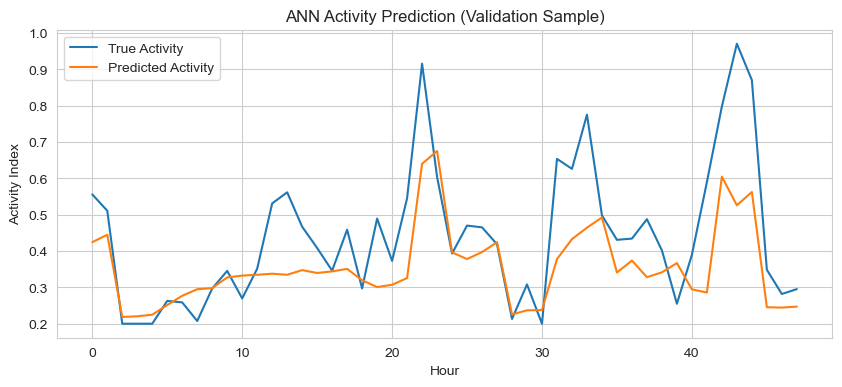

In [11]:
model.eval()
with torch.no_grad():
    sample_predictions = model(X_val_tensor[:48]).numpy().flatten()

plt.figure(figsize=(10, 4))
plt.plot(y_val[:48], label="True Activity")
plt.plot(sample_predictions, label="Predicted Activity")
plt.title("ANN Activity Prediction (Validation Sample)")
plt.xlabel("Hour")
plt.ylabel("Activity Index")
plt.legend()
plt.grid(True)
plt.show()


# 4. Evolutionary Optimization of Lighting Schedule

In [12]:
# Compute mean activity and visibility per hour
hourly_data = dataset.groupby("hour").mean(numeric_only=True)

activity_hourly = hourly_data["activity_index"].values
visibility_hourly = hourly_data["visibility"].values

HOURS = 24


In [13]:
# Static baseline: dim lighting at night, full during evening
baseline_schedule = np.zeros(HOURS, dtype=int)

for h in range(HOURS):
    if 18 <= h <= 23 or 0 <= h <= 5:
        baseline_schedule[h] = 2  # full
    else:
        baseline_schedule[h] = 1  # dim


In [14]:
# Energy cost per lighting level
ENERGY_COST = {0: 0.0, 1: 0.5, 2: 1.0}

# Weights for trade-off
LAMBDA_ENERGY = 0.4
LAMBDA_SAFETY = 0.5
DARKNESS_RISK = 1.2


# Night-time minimum lighting penalty (optional)
def night_penalty(hour, level):
    if (hour >= 22 or hour <= 6) and level == 0:
        return 2.5  # add penalty for turning off at night
    return 0.0

baseline_schedule = np.zeros(HOURS, dtype=int)
for h in range(HOURS):
    if 18 <= h <= 23 or 0 <= h <= 5:
        baseline_schedule[h] = 2
    else:
        baseline_schedule[h] = 1


In [15]:
# --- EA CORE FUNCTIONS ---

def fitness(schedule):
    """
    Calculates the fitting of the schedule, the less the better
    Normalised to ~[0, 1].
    """
    # Energy cost
    energy_sum = sum(ENERGY_COST[level] for level in schedule)
    max_possible_energy = HOURS * 1.0
    energy_norm = energy_sum / max_possible_energy

    # Safety cost
    safety_penalty = 0.0
    for h in range(HOURS):
        # Basic risk - lot of people & poor visibility
        base_risk = activity_hourly[h] * (2 - visibility_hourly[h])

        # Darkness risk -> the darker the worse
        # If schedule[h]=2 -> (2-2)=0 no risk
        # If schedule[h]=0 -> (2-0)=2 max risk
        dark_risk = DARKNESS_RISK * (2 - schedule[h])

        # Special penalty for the night
        np_penalty = night_penalty(h, schedule[h])

        safety_penalty += base_risk + dark_risk + np_penalty

    # Safety normalization
    safety_norm = safety_penalty / (HOURS * 3.0)

    return LAMBDA_ENERGY * energy_norm + LAMBDA_SAFETY * safety_norm

def mutate(schedule, mutation_rate=0.1):
    new_schedule = schedule.copy()
    for h in range(HOURS):
        if np.random.random() < mutation_rate:
            new_schedule[h] = np.random.randint(0, 3)
    return new_schedule

def crossover(parent1, parent2):
    point = np.random.randint(1, HOURS - 1)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2

In [16]:
# --- EA EXECUTION ---

# Parameters
POP_SIZE = 50
N_GENERATIONS = 100
MUTATION_RATE = 0.1
ELITISM_COUNT = 2

# Inicjalizacja populacji

population = [np.zeros(HOURS, dtype=int) for _ in range(POP_SIZE)]
best_fitness_history = []
best_schedule = None
best_fitness_val = float('inf')

print(f"Starting EA optimization ({N_GENERATIONS} generations)...")

for gen in range(N_GENERATIONS):

    fitnesses = np.array([fitness(ind) for ind in population])

    current_best_idx = np.argmin(fitnesses)
    current_best_fit = fitnesses[current_best_idx]

    if current_best_fit < best_fitness_val:
        best_fitness_val = current_best_fit
        best_schedule = population[current_best_idx].copy()

    best_fitness_history.append(current_best_fit)

    sorted_indices = np.argsort(fitnesses)
    # take 50% best
    survivors = [population[i] for i in sorted_indices[:POP_SIZE // 2]]

    new_population = []

    for i in range(ELITISM_COUNT):
        new_population.append(population[sorted_indices[i]])

    while len(new_population) < POP_SIZE:
        p1 = survivors[np.random.randint(len(survivors))]
        p2 = survivors[np.random.randint(len(survivors))]

        c1, c2 = crossover(p1, p2)

        new_population.append(mutate(c1, MUTATION_RATE))
        if len(new_population) < POP_SIZE:
            new_population.append(mutate(c2, MUTATION_RATE))

    population = new_population

print(f"Optimization finished.")
print(f"Baseline Fitness: {fitness(baseline_schedule):.4f}")
print(f"Best EA Fitness:  {best_fitness_val:.4f}")

Starting EA optimization (100 generations)...
Optimization finished.
Baseline Fitness: 0.4901
Best EA Fitness:  0.4901


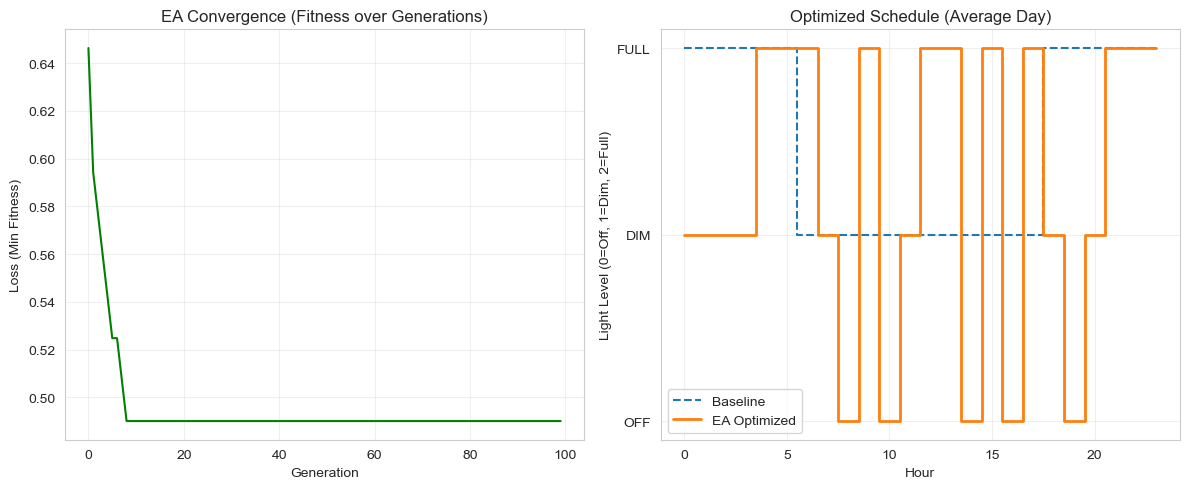

In [17]:
# --- ANALYSIS: AVERAGE DAY ---

plt.figure(figsize=(12, 5))

# convergence
plt.subplot(1, 2, 1)
plt.plot(best_fitness_history, color='green')
plt.title("EA Convergence (Fitness over Generations)")
plt.xlabel("Generation")
plt.ylabel("Loss (Min Fitness)")
plt.grid(True, alpha=0.3)

# schedule
plt.subplot(1, 2, 2)
plt.step(range(HOURS), baseline_schedule, where='mid', label='Baseline', linestyle='--')
plt.step(range(HOURS), best_schedule, where='mid', label='EA Optimized', linewidth=2)
plt.title("Optimized Schedule (Average Day)")
plt.xlabel("Hour")
plt.ylabel("Light Level (0=Off, 1=Dim, 2=Full)")
plt.yticks([0, 1, 2], ['OFF', 'DIM', 'FULL'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Fuzzy Logic Controller Design

In [18]:
# Normalize visibility: 0 (poor), 1 (moderate), 2 (good) → [0, 1]
visibility_norm = visibility_hourly / 2.0

import numpy as np

def trimf(x, a, b, c):
    """
    Robust triangular membership function (like skfuzzy.trimf).

    Parameters
    ----------
    x : float or np.ndarray
        Input value(s).
    a, b, c : float
        Triangle parameters with a <= b <= c.

    Returns
    -------
    mu : float or np.ndarray
        Membership degree(s) in [0, 1].
    """
    return np.maximum(0, np.minimum((x - a) / (b - a + 1e-9), (c - x) / (c - b + 1e-9)))

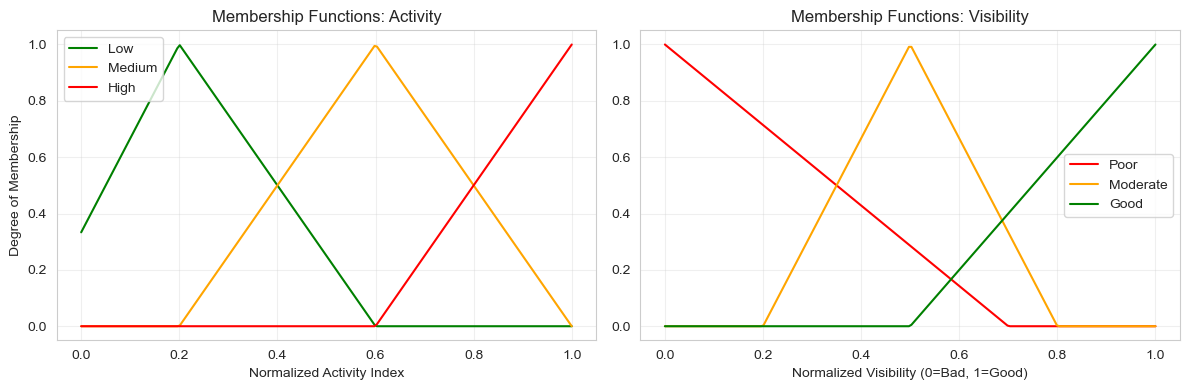

In [19]:
def activity_low(x):    return trimf(x, -0.1, 0.2, 0.6)
def activity_medium(x): return trimf(x, 0.2, 0.6, 1.0)
def activity_high(x):   return trimf(x, 0.6, 1.0, 1.1)

def visibility_poor(x):     return trimf(x, -0.1, 0.0, 0.7)
def visibility_moderate(x): return trimf(x, 0.2, 0.5, 0.8)
def visibility_good(x):     return trimf(x, 0.5, 1.0, 1.1)

x_axis = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 4))

# Activity
plt.subplot(1, 2, 1)
plt.plot(x_axis, activity_low(x_axis), label="Low", color="green")
plt.plot(x_axis, activity_medium(x_axis), label="Medium", color="orange")
plt.plot(x_axis, activity_high(x_axis), label="High", color="red")
plt.title("Membership Functions: Activity")
plt.xlabel("Normalized Activity Index")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True, alpha=0.3)

# visibility
plt.subplot(1, 2, 2)
plt.plot(x_axis, visibility_poor(x_axis), label="Poor", color="red")
plt.plot(x_axis, visibility_moderate(x_axis), label="Moderate", color="orange")
plt.plot(x_axis, visibility_good(x_axis), label="Good", color="green")
plt.title("Membership Functions: Visibility")
plt.xlabel("Normalized Visibility (0=Bad, 1=Good)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
def get_fuzzy_priority(activity, visibility):

    act_lo = trimf(activity, -0.1, 0.0, 0.5)

    act_md = trimf(activity, 0.3, 0.6, 0.9)

    act_hi = trimf(activity, 0.7, 1.0, 1.1)

    vis_po = trimf(visibility, -0.1, 0.0, 0.6)
    vis_md = trimf(visibility, 0.4, 0.7, 1.0)
    vis_gd = trimf(visibility, 0.8, 1.0, 1.1)

    fire_high = np.maximum(vis_po, act_hi)

    fire_medium = np.maximum(vis_md, act_md)

    fire_low = np.minimum(act_lo, vis_gd)

    numerator = (fire_high * 1.0) + (fire_medium * 0.5) + (fire_low * 0.1)
    denominator = fire_high + fire_medium + fire_low

    if denominator == 0:
        raw_output = 0.5
    else:
        raw_output = numerator / denominator

    if vis_po > 0.8:
        raw_output = max(raw_output, 0.5)

    return raw_output

In [21]:
# Sanity Check
print("Fuzzy Logic Sanity Check (Sample Hours):")
print("-" * 60)
for h in [0, 6, 12, 18]:
    act = activity_hourly[h]
    vis = visibility_norm[h]
    p = get_fuzzy_priority(act, vis)
    print(f"Hour {h:02d} | Act: {act:.2f} | Vis: {vis:.2f} -> Priority: {p:.2f}")


Fuzzy Logic Sanity Check (Sample Hours):
------------------------------------------------------------
Hour 00 | Act: 0.31 | Vis: 0.00 -> Priority: 0.98
Hour 06 | Act: 0.39 | Vis: 0.12 -> Priority: 0.86
Hour 12 | Act: 0.62 | Vis: 0.74 -> Priority: 0.50
Hour 18 | Act: 0.53 | Vis: 0.68 -> Priority: 0.50


# 6. EA-Based Tuning of Fuzzy Membership Functions

In [22]:
target_priority_curve = np.zeros(HOURS)
for h in range(HOURS):
    target_priority_curve[h] = get_fuzzy_priority(activity_hourly[h], visibility_norm[h])

def fitness_fuzzy(schedule):

    energy_sum = sum(ENERGY_COST[level] for level in schedule)
    energy_norm = energy_sum / (HOURS * 1.0)

    deviation_penalty = 0.0
    for h in range(HOURS):

        light_norm = schedule[h] / 2.0
        target = target_priority_curve[h]

        deviation_penalty += (light_norm - target) ** 2

        deviation_penalty += night_penalty(h, schedule[h])

    deviation_norm = deviation_penalty / HOURS

    # ratio between safety and the cost
    return 0.2 * energy_norm + 0.7 * deviation_norm

population = [np.random.randint(0, 3, size=HOURS) for _ in range(POP_SIZE)]
best_fuzzy_history = []
best_fuzzy_schedule = None
best_fuzzy_val = float('inf')

for gen in range(N_GENERATIONS):

    fitnesses = np.array([fitness_fuzzy(ind) for ind in population])

    current_best_idx = np.argmin(fitnesses)
    if fitnesses[current_best_idx] < best_fuzzy_val:
        best_fuzzy_val = fitnesses[current_best_idx]
        best_fuzzy_schedule = population[current_best_idx].copy()

    best_fuzzy_history.append(fitnesses[current_best_idx])

    survivors = [population[i] for i in np.argsort(fitnesses)[:POP_SIZE // 2]]
    new_population = []
    # Eliysm
    new_population.extend([population[i] for i in np.argsort(fitnesses)[:ELITISM_COUNT]])

    while len(new_population) < POP_SIZE:
        p1 = survivors[np.random.randint(len(survivors))]
        p2 = survivors[np.random.randint(len(survivors))]
        c1, c2 = crossover(p1, p2)
        new_population.append(mutate(c1, MUTATION_RATE))
        if len(new_population) < POP_SIZE:
            new_population.append(mutate(c2, MUTATION_RATE))

    population = new_population

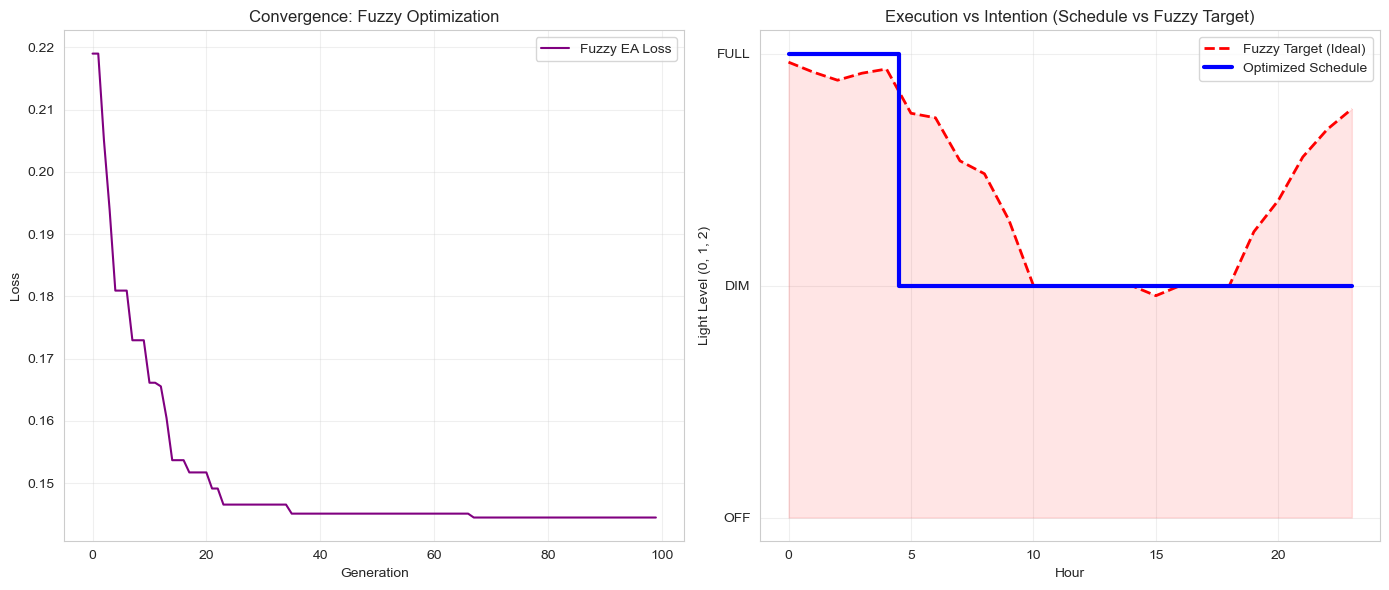

In [23]:
# --- RESULTS VISUALIZATION ---

plt.figure(figsize=(14, 6))

# convergence
plt.subplot(1, 2, 1)
plt.plot(best_fuzzy_history, label='Fuzzy EA Loss', color='purple')
plt.title("Convergence: Fuzzy Optimization")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Aim vs results
plt.subplot(1, 2, 2)

plt.plot(range(HOURS), target_priority_curve * 2, 'r--', label='Fuzzy Target (Ideal)', linewidth=2)

plt.step(range(HOURS), best_fuzzy_schedule, where='mid', label='Optimized Schedule', color='blue', linewidth=3)

plt.fill_between(range(HOURS), 0, target_priority_curve * 2, color='red', alpha=0.1)
plt.title("Execution vs Intention (Schedule vs Fuzzy Target)")
plt.xlabel("Hour")
plt.ylabel("Light Level (0, 1, 2)")
plt.yticks([0, 1, 2], ['OFF', 'DIM', 'FULL'])
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Starting Optimization (Floor: 0.2, Buffer: 0.05)...
Gen 01/30 | Best Fit: 1.6755
Gen 06/30 | Best Fit: 1.6133
Gen 11/30 | Best Fit: 1.6133
Gen 16/30 | Best Fit: 1.6133
Gen 21/30 | Best Fit: 1.6133
Gen 26/30 | Best Fit: 1.6133
Tuned Thresholds -> Act High Starts: 0.45, Vis Poor Ends: 0.66
Estimated Energy Usage: 66.67% 


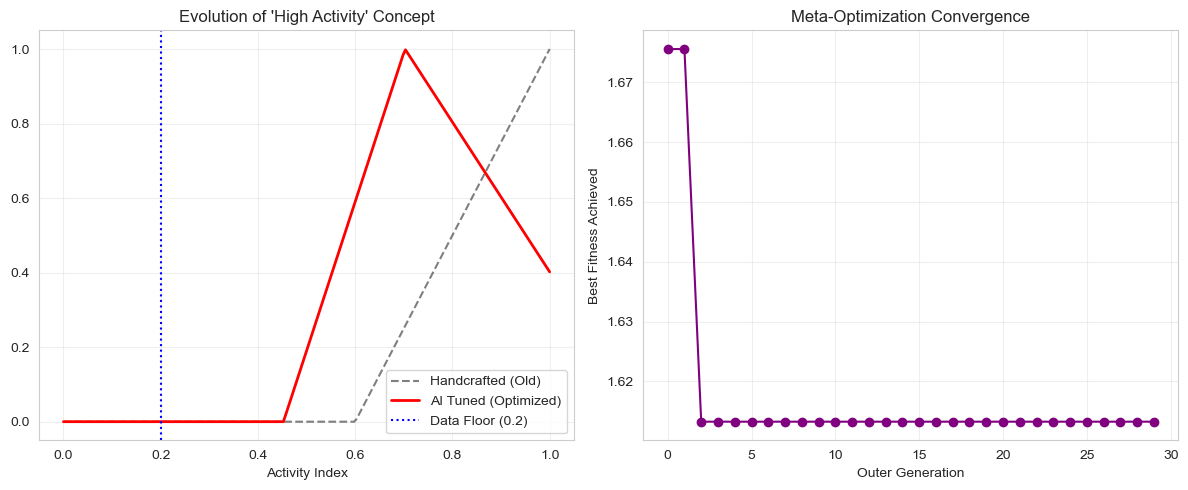

In [24]:
# ==========================================
# 10. META-OPTIMIZATION
# ==========================================
import time
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


# 1. CONFIGURATION
CHROM_DIM = 2
OUTER_POP = 50
OUTER_GEN = 30
OUTER_MUT_RATE = 0.15

ACTIVITY_FLOOR = 0.20
BUFFER = 0.05

rng_outer = np.random.default_rng(42)

def trimf(x, a, b, c):
    return np.maximum(0, np.minimum((x - a) / (b - a + 1e-9), (c - x) / (c - b + 1e-9)))

# 2. GENETICS
def random_chromosome():
    return rng_outer.random(CHROM_DIM)

def mutate_chromosome(chrom):
    c = chrom.copy()
    for i in range(CHROM_DIM):
        if rng_outer.random() < OUTER_MUT_RATE:
            c[i] = rng_outer.random()
    return c

# 3. UNPACK CHROMOSOME
def unpack_chromosome(chrom):
    # Logic: Search starts at 0.25.
    start_search = ACTIVITY_FLOOR + BUFFER
    span = 0.40

    aA = start_search + (chrom[0] * span)

    # "High Activity" Triangle
    act_params = [aA, aA + 0.25, 1.2]

    # "Poor Visibility" Triangle
    end_poor = chrom[1] * 0.8
    vis_params = [-0.1, 0.0, end_poor]

    return act_params, vis_params

# 4. FUZZY LOGIC
def fuzzy_priority_tuned(activity, visibility, act_params, vis_params):
    aA, bA, cA = act_params
    aV, bV, cV = vis_params

    act_hi = trimf(activity, aA, bA, cA)
    vis_po = trimf(visibility, aV, bV, cV)

    return np.maximum(act_hi, vis_po)

# 5. FITNESS FUNCTION
def optimize_schedule_strict(chrom, seed=None):
    act_params, vis_params = unpack_chromosome(chrom)

    local_target = np.zeros(HOURS)
    for h in range(HOURS):
        local_target[h] = fuzzy_priority_tuned(
            activity_hourly[h], visibility_norm[h], act_params, vis_params
        )

    if np.sum(local_target) < 0.5: return 99999.0

    ideal_schedule = np.round(local_target * 2.0).astype(int)

    # Energy Score
    current_cost = np.sum([ENERGY_COST[l] for l in ideal_schedule])
    energy_score = current_cost / (ENERGY_COST[2] * HOURS)

    # Risk Score
    risk_score = 0.0
    for h in range(HOURS):
        required = max(activity_hourly[h], (1.0 - visibility_norm[h]))
        provided = ideal_schedule[h] / 2.0
        if provided < required:
            risk_score += (required - provided) ** 2
    risk_score = risk_score / HOURS

    # --- WEIGHTS FOR ~60% ENERGY ---
    # Energy weight lowered to 2.0
    # Risk weight increased to 12.0
    total_fitness = (energy_score * 2.0) + (risk_score * 12.0)

    return total_fitness

def outer_fitness(chrom, eval_seed=0):
    return optimize_schedule_strict(chrom, seed=eval_seed)

# 6. EXECUTION
outer_population = [random_chromosome() for _ in range(OUTER_POP)]
best_chrom = None
best_fit = np.inf
best_outer_history = []

print(f"Starting Optimization (Floor: {ACTIVITY_FLOOR}, Buffer: {BUFFER})...")

for gen in range(OUTER_GEN):
    fits = Parallel(n_jobs=-1)(delayed(outer_fitness)(c) for c in outer_population)
    fits = np.array(fits)

    gen_best_idx = np.argmin(fits)
    gen_best_fit = fits[gen_best_idx]
    best_outer_history.append(gen_best_fit)

    if gen_best_fit < best_fit:
        best_fit = gen_best_fit
        best_chrom = outer_population[gen_best_idx].copy()

    if gen % 5 == 0:
        print(f"Gen {gen+1:02d}/{OUTER_GEN} | Best Fit: {gen_best_fit:.4f}")

    idx = np.argsort(fits)[:OUTER_POP//2]
    survivors = [outer_population[i] for i in idx]
    new_pop = survivors.copy()
    while len(new_pop) < OUTER_POP:
        p = survivors[np.random.randint(len(survivors))]
        new_pop.append(mutate_chromosome(p))
    outer_population = new_pop

tuned_act, tuned_pri = unpack_chromosome(best_chrom)
print(f"Tuned Thresholds -> Act High Starts: {tuned_act[0]:.2f}, Vis Poor Ends: {tuned_pri[2]:.2f}")

# Verify Energy
final_act, final_vis = unpack_chromosome(best_chrom)
test_target = [fuzzy_priority_tuned(activity_hourly[h], visibility_norm[h], final_act, final_vis) for h in range(HOURS)]
test_sched = np.round(np.array(test_target) * 2.0).astype(int)
final_energy = np.sum([ENERGY_COST[l] for l in test_sched]) / (HOURS * 1.0) * 100
print(f"Estimated Energy Usage: {final_energy:.2f}% ")

# --- PLOTTING SECTION 10 ---
x_axis = np.linspace(0, 1, 200)

plt.figure(figsize=(12, 5))

# 1. Activity High Comparison
plt.subplot(1, 2, 1)
# Handcrafted Baseline (Old logic)
# Standard Trimf: a=0.6, b=1.0, c=1.0
plt.plot(x_axis, trimf(x_axis, 0.6, 1.0, 1.2), 'k--', label='Handcrafted (Old)', alpha=0.5)
# AI Tuned (New)
plt.plot(x_axis, trimf(x_axis, *tuned_act), 'r-', label='AI Tuned (Optimized)', linewidth=2)

plt.axvline(ACTIVITY_FLOOR, color='blue', linestyle=':', label='Data Floor (0.2)')
plt.title("Evolution of 'High Activity' Concept")
plt.xlabel("Activity Index")
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Convergence History
plt.subplot(1, 2, 2)
plt.plot(best_outer_history, marker='o', color='purple')
plt.title("Meta-Optimization Convergence")
plt.xlabel("Outer Generation")
plt.ylabel("Best Fitness Achieved")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


RESUKTS TABLE:
           Method  Energy_Pct  Safety Risk
0        Baseline       75.00        27.38
1     Standard EA       62.50        34.58
2        Fuzzy EA       60.42        35.78
3  Tuned Fuzzy EA       45.83        44.18


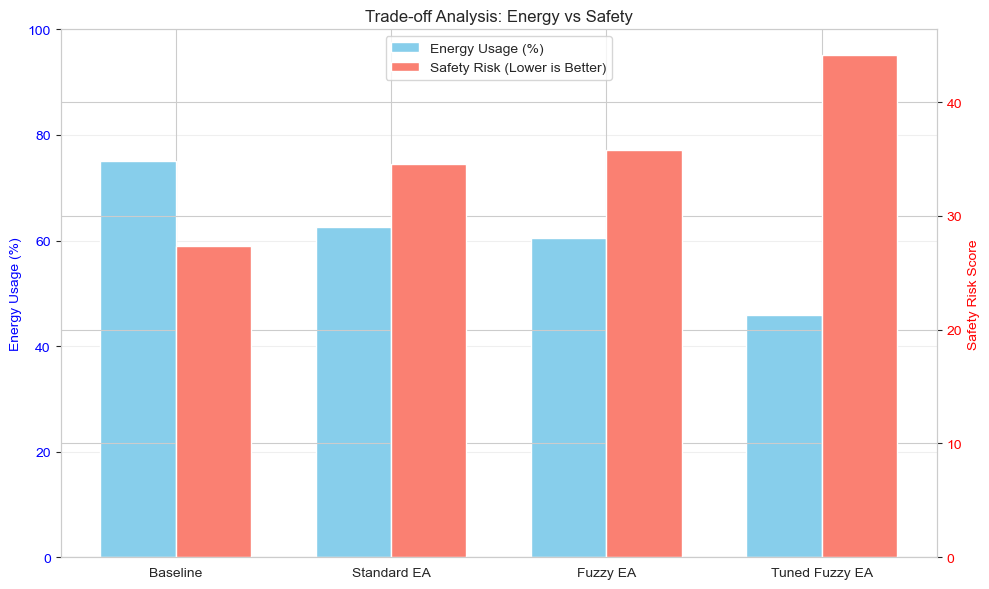

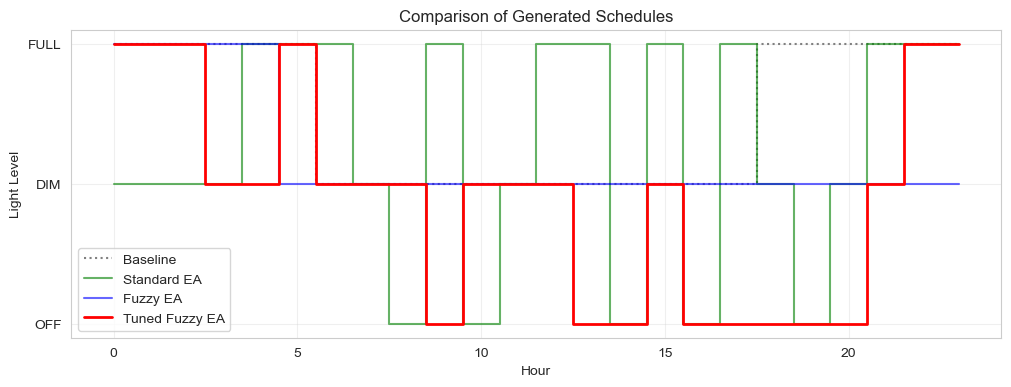

In [25]:
# ==========================================
# 11. FINAL COMPARATIVE ANALYSIS (GRAND FINALE)
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt

tuned_act_best, tuned_pri_best = unpack_chromosome(best_chrom)

tuned_target_curve = np.zeros(HOURS)
for h in range(HOURS):
    tuned_target_curve[h] = fuzzy_priority_tuned(
        activity_hourly[h], visibility_norm[h], tuned_act_best, tuned_pri_best
    )

def get_schedule_from_target(target_curve):
    temp_pop = [np.random.randint(0, 3, size=HOURS) for _ in range(30)]
    for _ in range(50):
        fits = []
        for ind in temp_pop:
            dev = np.mean((ind/2.0 - target_curve)**2)
            eng = sum(ENERGY_COST[l] for l in ind)/HOURS
            fits.append(0.7*dev + 0.3*eng)

        survivors = [temp_pop[i] for i in np.argsort(fits)[:15]]
        temp_pop = survivors.copy()
        while len(temp_pop) < 30:
            p = survivors[np.random.randint(len(survivors))].copy()

            if np.random.rand() < 0.2:
                idx = np.random.randint(HOURS)
                p[idx] = np.random.randint(0, 3)
            temp_pop.append(p)

    fits = []
    for ind in temp_pop:
        dev = np.mean((ind/2.0 - target_curve)**2)
        eng = sum(ENERGY_COST[l] for l in ind)/HOURS
        fits.append(0.7*dev + 0.3*eng)
    return temp_pop[np.argmin(fits)]

best_tuned_schedule = get_schedule_from_target(tuned_target_curve)

def calculate_metrics(schedule, name):

    energy_raw = sum(ENERGY_COST[l] for l in schedule)
    energy_pct = (energy_raw / HOURS) * 100

    risk_score = 0.0
    for h in range(HOURS):
        base = activity_hourly[h] * (2 - visibility_hourly[h])
        dark = DARKNESS_RISK * (2 - schedule[h])
        pen = night_penalty(h, schedule[h])
        risk_score += base + dark + pen

    return {
        "Method": name,
        "Energy (%)": energy_raw,
        "Energy_Pct": energy_pct,
        "Safety Risk": risk_score
    }

results = []
results.append(calculate_metrics(baseline_schedule, "Baseline"))
results.append(calculate_metrics(best_schedule, "Standard EA"))
results.append(calculate_metrics(best_fuzzy_schedule, "Fuzzy EA"))
results.append(calculate_metrics(best_tuned_schedule, "Tuned Fuzzy EA"))

df_results = pd.DataFrame(results)

# 4. Wizualizacja Porównawcza
print("\nRESUKTS TABLE:")
print(df_results[["Method", "Energy_Pct", "Safety Risk"]].round(2))

# Wykres
fig, ax1 = plt.subplots(figsize=(10, 6))

# Słupki Energii
x = np.arange(len(df_results))
width = 0.35

bars1 = ax1.bar(x - width/2, df_results["Energy_Pct"], width, label='Energy Usage (%)', color='skyblue')
ax1.set_ylabel('Energy Usage (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 100)

# Linia/Słupki Ryzyka (na drugiej osi)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, df_results["Safety Risk"], width, label='Safety Risk (Lower is Better)', color='salmon')
ax2.set_ylabel('Safety Risk Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_xticks(x)
ax1.set_xticklabels(df_results["Method"])
ax1.set_title("Trade-off Analysis: Energy vs Safety")
ax1.grid(True, axis='y', alpha=0.3)

# Legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.tight_layout()
plt.show()

# 5. Wykres Harmonogramów (Wszystkie na jednym)
plt.figure(figsize=(12, 4))
plt.step(range(HOURS), baseline_schedule, where='mid', label='Baseline', linestyle=':', color='gray')
plt.step(range(HOURS), best_schedule, where='mid', label='Standard EA', color='green', alpha=0.6)
plt.step(range(HOURS), best_fuzzy_schedule, where='mid', label='Fuzzy EA', color='blue', alpha=0.6)
plt.step(range(HOURS), best_tuned_schedule, where='mid', label='Tuned Fuzzy EA', color='red', linewidth=2)

plt.yticks([0, 1, 2], ['OFF', 'DIM', 'FULL'])
plt.title("Comparison of Generated Schedules")
plt.xlabel("Hour")
plt.ylabel("Light Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

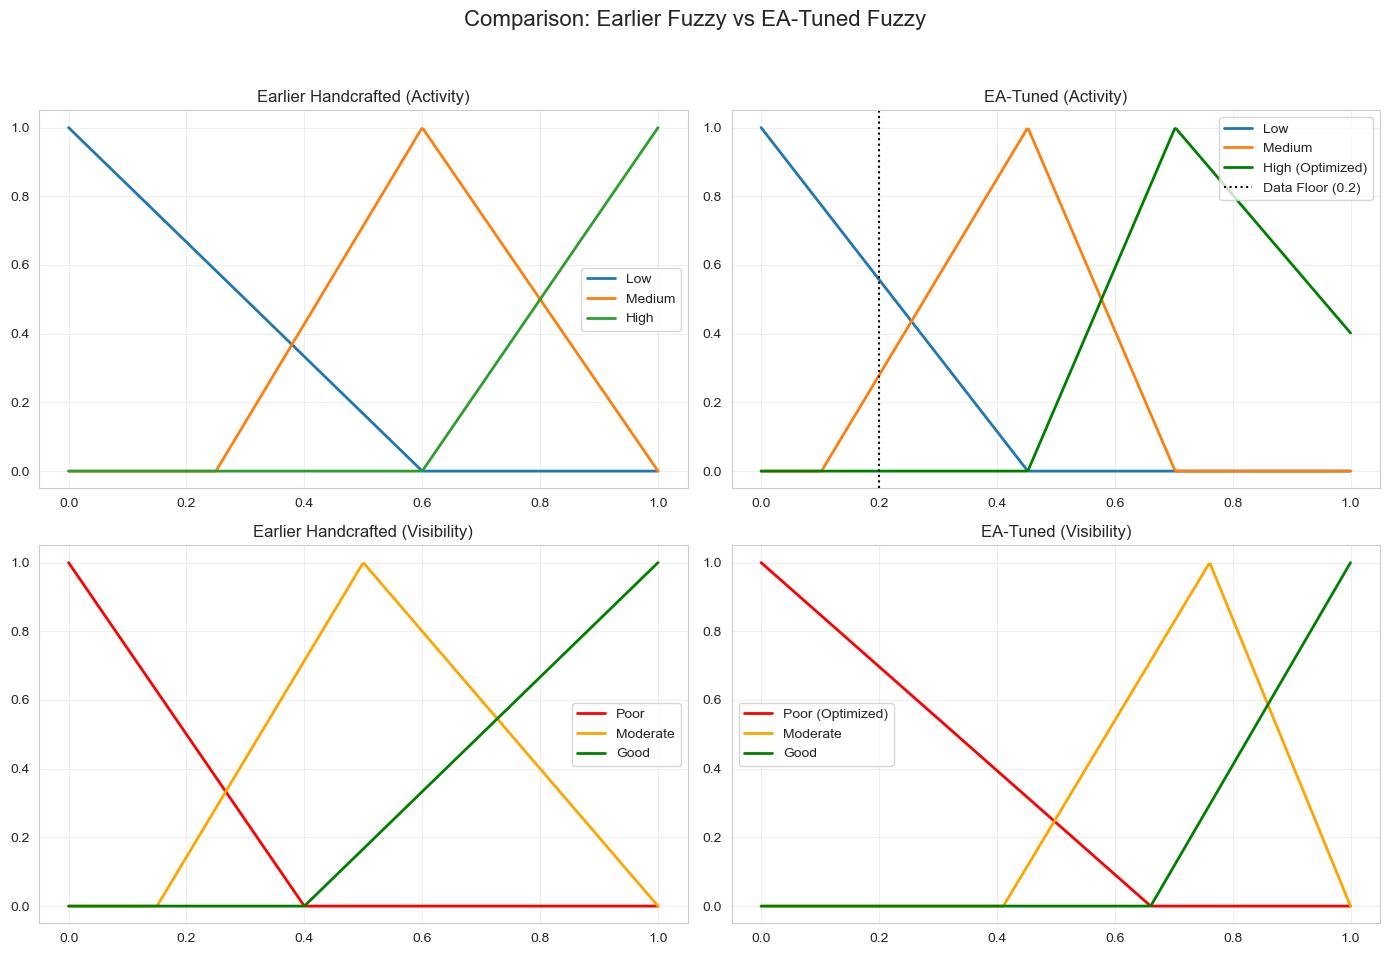

In [26]:
# ==========================================
# VISUALIZATION: HANDCRAFTED VS TUNED (FIXED)
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

def get_fuzzy_shapes(xx, optimized_params, type_mode='activity'):
    """
    Returns y_low, y_med, y_high/y_poor based on the main triangle parameters.
    """
    a, b, c = optimized_params

    if type_mode == 'activity':
        y_high = trimf(xx, a, b, c)

        med_peak = a
        med_end = b
        med_start = max(0, a - 0.35)
        y_med = trimf(xx, med_start, med_peak, med_end)

        y_low = trimf(xx, -0.1, 0.0, a)

        return y_low, y_med, y_high

    elif type_mode == 'visibility':
        y_poor = trimf(xx, a, b, c)

        mod_start = max(0, c - 0.25)
        mod_peak = c + 0.1
        y_mod = trimf(xx, mod_start, mod_peak, 1.0)

        y_good = trimf(xx, c, 1.0, 1.2)

        return y_poor, y_mod, y_good


hand_act_params = [0.6, 1.0, 1.2]
hand_vis_params = [-0.1, 0.0, 0.4]

if 'tuned_act' in locals():
    tuned_act_params = tuned_act
    tuned_vis_params = tuned_pri
else:
    tuned_act_params = [0.35, 0.6, 1.2]
    tuned_vis_params = [-0.1, 0.0, 0.7]

xx = np.linspace(0, 1, 400)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Comparison: Earlier Fuzzy vs EA-Tuned Fuzzy", fontsize=16)


y_l, y_m, y_h = get_fuzzy_shapes(xx, hand_act_params, 'activity')
axes[0,0].plot(xx, y_l, label='Low', linewidth=2)
axes[0,0].plot(xx, y_m, label='Medium', linewidth=2)
axes[0,0].plot(xx, y_h, label='High', linewidth=2)
axes[0,0].set_title("Earlier Handcrafted (Activity)")
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

y_l, y_m, y_h = get_fuzzy_shapes(xx, tuned_act_params, 'activity')
axes[0,1].plot(xx, y_l, label='Low', linewidth=2)
axes[0,1].plot(xx, y_m, label='Medium', linewidth=2)
axes[0,1].plot(xx, y_h, label='High (Optimized)', linewidth=2, color='green')

axes[0,1].axvline(ACTIVITY_FLOOR, color='black', linestyle=':', label=f'Data Floor ({ACTIVITY_FLOOR})')
axes[0,1].set_title("EA-Tuned (Activity)")
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

y_p, y_m, y_g = get_fuzzy_shapes(xx, hand_vis_params, 'visibility')
axes[1,0].plot(xx, y_p, label='Poor', linewidth=2, color='red')
axes[1,0].plot(xx, y_m, label='Moderate', linewidth=2, color='orange')
axes[1,0].plot(xx, y_g, label='Good', linewidth=2, color='green')
axes[1,0].set_title("Earlier Handcrafted (Visibility)")
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

y_p, y_m, y_g = get_fuzzy_shapes(xx, tuned_vis_params, 'visibility')
axes[1,1].plot(xx, y_p, label='Poor (Optimized)', linewidth=2, color='red')
axes[1,1].plot(xx, y_m, label='Moderate', linewidth=2, color='orange')
axes[1,1].plot(xx, y_g, label='Good', linewidth=2, color='green')
axes[1,1].set_title("EA-Tuned (Visibility)")
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [27]:
import numpy as np

LAMBDA_RISK = 50.0

def robust_fitness(schedule, target_curve):
    """Oblicza fitness z silną karą za ryzyko."""
    HOURS = len(schedule)

    energy_cost = np.sum([ENERGY_COST[l] for l in schedule])
    energy_norm = energy_cost / HOURS

    light_levels = schedule / 2.0
    diff = target_curve - light_levels

    risk_penalty = 0.0
    for h in range(HOURS):
        d = diff[h]
        if d > 0:
            risk_penalty += (d ** 2) * LAMBDA_RISK
        else:
            risk_penalty += (d ** 2) * 0.5

    risk_norm = risk_penalty / HOURS

    hard_penalty = 0.0
    for h, level in enumerate(schedule):
        hard_penalty += night_penalty(h, level)

    return energy_norm + risk_norm + hard_penalty

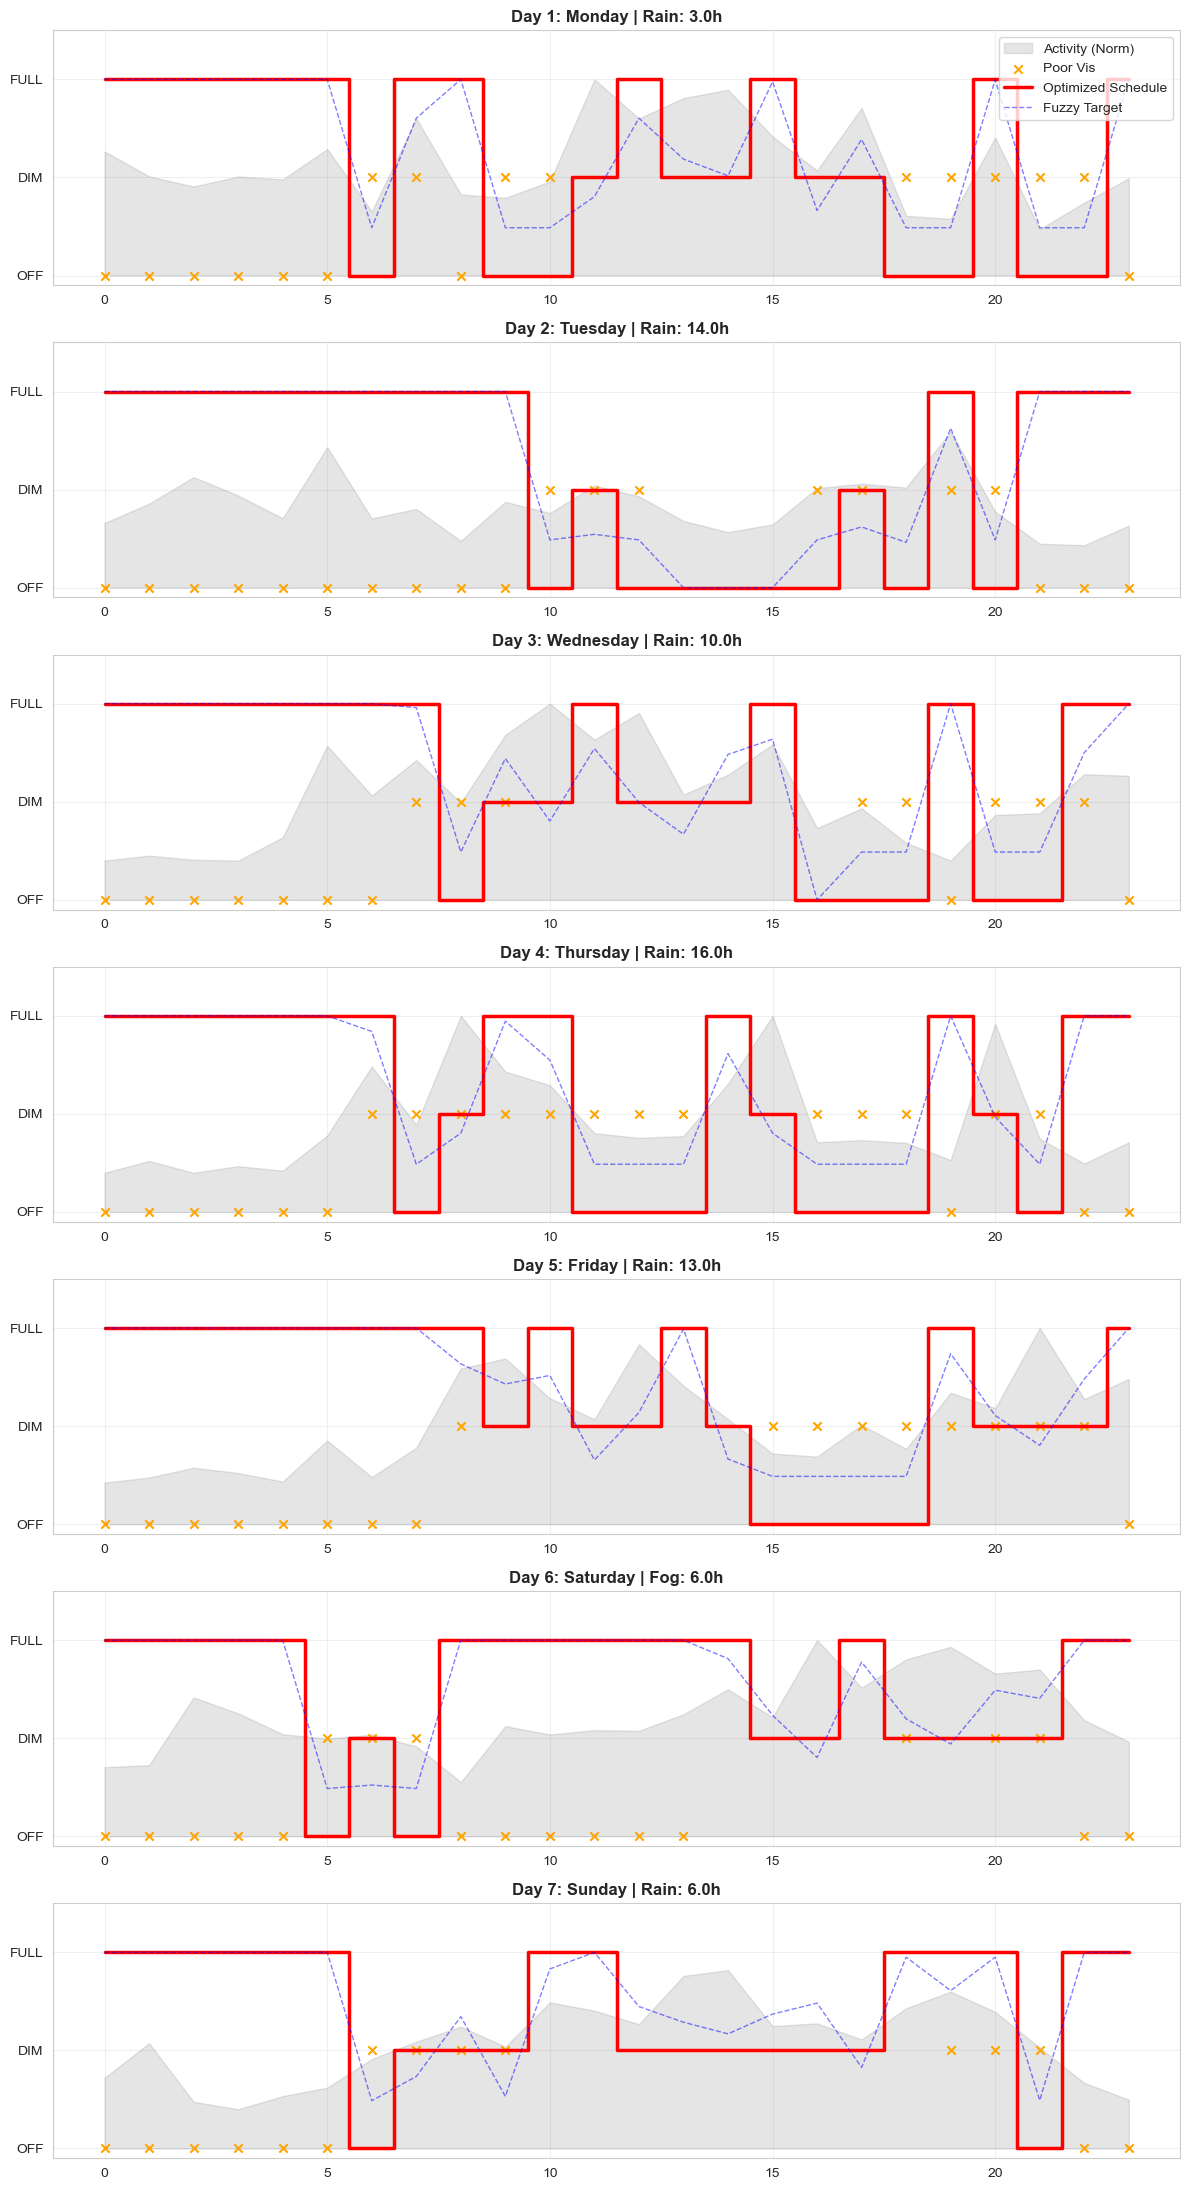

In [28]:
# ==========================================
# 13. DYNAMIC SCHEDULING (FINAL OPTIMIZED)
# ==========================================

if 'tuned_act' not in locals():
    tuned_act = (0.2, 0.5, 1.2)
    tuned_pri = (-0.1, 0.0, 0.6)

GLOBAL_MAX_ACT = np.percentile(dataset['activity_index'], 99.5)
if GLOBAL_MAX_ACT == 0: GLOBAL_MAX_ACT = 1.0


def solve_for_day_fast(daily_target_curve):
    return np.round(daily_target_curve * 2.0).astype(int)

days_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(7, 1, figsize=(12, 22))

for day_idx in range(7):
    ax = axes[day_idx]
    start = day_idx * 24
    end = start + 24

    day_vis = dataset['visibility'].iloc[start:end].values
    day_act_raw = dataset['activity_index'].iloc[start:end].values

    day_vis_norm = day_vis / 2.0
    day_act_norm = day_act_raw / GLOBAL_MAX_ACT
    day_act_norm = np.clip(day_act_norm, 0.0, 1.0)

    day_target_curve = np.zeros(HOURS)
    for h in range(HOURS):
        day_target_curve[h] = fuzzy_priority_tuned(
            day_act_norm[h],
            day_vis_norm[h],
            tuned_act,
            tuned_pri
        )

    day_schedule = solve_for_day_fast(day_target_curve)

    day_name = days_of_week_names[int(dataset['day_of_week'].iloc[start])]
    rain = dataset['rain'].iloc[start:end].sum()
    fog = dataset['fog'].iloc[start:end].sum()

    title = f"Day {day_idx+1}: {day_name}"
    if rain > 0: title += f" | Rain: {rain:.1f}h"
    if fog > 0: title += f" | Fog: {fog:.1f}h"

    ax.fill_between(range(24), 0, day_act_norm * 2.0, color='gray', alpha=0.2, label='Activity (Norm)')

    bad_vis = day_vis < 2
    if np.any(bad_vis):
        ax.scatter(np.where(bad_vis)[0], day_vis[bad_vis], color='orange', marker='x', label='Poor Vis')

    ax.step(range(24), day_schedule, where='mid', color='red', linewidth=2.5, label='Optimized Schedule')

    ax.plot(range(24), day_target_curve * 2.0, 'b--', linewidth=1, alpha=0.5, label='Fuzzy Target')

    ax.set_title(title, fontweight='bold')
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['OFF', 'DIM', 'FULL'])
    ax.set_ylim(-0.1, 2.5)
    ax.grid(True, alpha=0.3)

    if day_idx == 0: ax.legend(loc='upper right')

plt.tight_layout()
plt.show()